## PSF quantification script

<details>
  <summary>>>Click to expand</summary>
    
Written by Nicholas Sofroniew, modified by Adam Glaser & Kevin Bishop

This script computes the average PSF size from a volume of diffraction limited beads for the purposes of characterizing microscope resolution.

Usage: A relatively small (~1mm^3 or less) data volume should be collected, ensuring SBR is moderately high (50 - 100x). The volume should be fused as a TIFF stack (16 bit, no downsampling, one channel per stack) sliced along the XY (highest resolution) plane. To achieve this, open the hdf5 dataset in BigStitcher, *Multiview > right-click > Interactively reorient sample...* Press *shift + Y* to orient the sample view in the XY (highest resolution) plane and click *Apply tranformation*. Define a bounding box (to fuse a subvolume if the dataset is large) and fuse to a compressed TIFF stack. Finally open the TIFF stack in FIJI (import as virtual stack for faster loading). Confirm that each single image shows the XY plane - the PSF should look circular and symmetric, not stretched. Click *Image > properties* and note the pixel sampling (width / height / depth; should all be the same) to input below.

Note: the script may take several hours to run (particularly the 'getting centers | Smoothing...' step)
    
**Note on colormaps**

Heatmaps are colored using the [vik colormap](https://www.fabiocrameri.ch/colourmaps/) by Fabio Crameri, available as a python package via pip: ```pip install cmcrameri```. This is scientific colormap which is perceptually uniform and ordered, and is color-vision-deficiency friendly. The colormap is diverging and centered about the median PSF size. In other words, red colors indicate PSFs *larger* than the median while blue colors indicate PSFs *smaller* than the median, with color intensity indicating how far the value is from the median.



## Coordinate convention
- First frame in TIFF stack is z=0
- TOP left of TIFF frame x=0, y=0
- NOTE: plots start with 0,0 (of whichever axes you choose) in the BOTTOM left

**It seems like the X and Y FWHM values may be flipped, i.e. x_center goes with y_FWHM**

## Setup environment

In [1]:
import os
import numpy as np
import json
from skimage.io import imread
from skimage.io import imsave
import pandas
import warnings
import time
import scipy.stats

from psf import compute

import plotting.plotting as psf_plot

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap

# Optional, uncomment to use color maps from Fabio Crameri:
# https://doi.org/10.5281/zenodo.1243862
#from cmcrameri import cm




In [2]:
# Use this to reload changed plotting functions without restarting notebook
from importlib import reload
reload(psf_plot)

<module 'plotting.plotting' from 'C:\\Users\\AERB\\Documents\\Kevin\\Bead_PSF_computation\\plotting\\plotting.py'>

## Define plotting style

In [3]:
# run this line regardless to reset any prior styles
plt.style.use('default')


# To plot with a specific style, run one of the lines below or define a new style:
# run this line for inline display
plt.style.use('./styles/display.mplstyle')

# run this line to save for paper display
# plt.style.use('./styles/optica_abstract_heat.mplstyle')

## Define parameters

In [4]:
sampling = 0.2719532680443462 # um/px - see instructions above
wavelength = 638.0 # nm
NA = 0.4 * 1.56 # approximate collection NA
bead_size = 0.150 # um
# Note: sampling, wavelength, NA, and bead_size are only used to make an initial guess of the Gaussian fit,
# they do not otherwise impact bead results (other than sampling being used in plots convert px to um)

windowUm = [8, 4, 4] # um - generally a few times the expected resolution. Too big may slow down script, 
                     # too small may truncate PSFs.
thresh_mode = 'abs'  # 'abs': thresh is minimum raw pixel value of bead peak to be counted
                     # 'rel': thresh is minimum [bead peak] / [image max] to be counted
thresh = 1000
min_dist = 5 # um, min distance between adjacent beads and between beads and volume edge to be counted
rotation = False # Allow a rotational component in the 3D Gaussian fit, e.g. to analyze systems with a
                 # titled PSF. NOTE: each bead fit is rotated independently, meaning the x/y/z axes for
                 # FWHM measurements may be different from the x/y/z axes for bead position, and that 
                 # the FWHM measurement axes may vary from bead to bead. Proceed with caution - additional
                 # analysis steps to account for rotation, not provided here, may be needed.

options = {'pxPerUmLat':1.0/sampling,
           'pxPerUmAx':1.0/sampling,
           'wavelength':wavelength,
           'NA':NA,
           'bead_size':bead_size,
           'windowUm':windowUm,
           'thresh':thresh,
           'thresh_mode':thresh_mode,
           'min_dist':round(min_dist/sampling),
           'rotation':rotation}

# tiff stack should be placed in its own directory
data_base_path = 'H:\\Kevin\\Nature Protocols raw data\\OTLS4_ECi_beads_11-21-22_256px_2mW'
tiff_name = 'fused_tp_0_ch_0_mid-tile.tif'

**Example:**


<div>
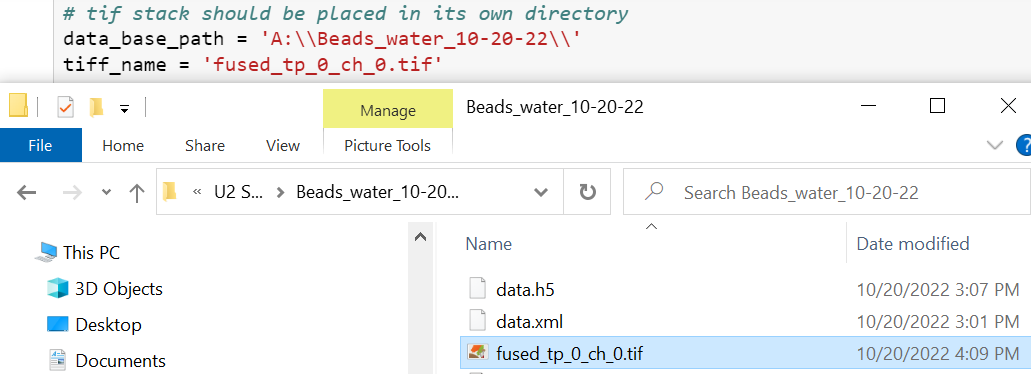
</div>

## Compute PSFs
Run this cell to generate new PSF data (may take several hours to run)

In [5]:
try: data
except NameError:
    print('Computing PSF data')
    
    start = time.time()
    
    tiff_path = os.path.join(data_base_path,tiff_name)
    im = imread(tiff_path, plugin='tifffile')
    data, smoothed = compute(im, options)
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Execution time: {:0>2}hrs {:0>2}mins {:05.2f}secs".format(int(hours),int(minutes),seconds))
    
else: print('Error data is already defined! To recompute, delete \'data\' variable (\'del data\') and try again')


Computing PSF data
getting centers
Smoothing...
Smoothed max:  47575.37152119154
Finding centers...
threshold_abs: 1000
Found 9193 beads
Keeping 7150 beads
Finding maxima
got centers
Found bounds
Computing PSFs...
Found PSFs
Execution time: 00hrs 38mins 08.27secs


## Save raw data
Run this cell to save raw data generated above

In [6]:
# Save as pickle - WILL save full PSF data, large file size
save_path = os.path.join(data_base_path, 'PSF_data.pkl')
if not os.path.exists(save_path):
    print('Saving data...')
    data.to_pickle(save_path)
    print('Done')
else:
    raise Exception('File already exists')

Saving data...
Done


In [7]:
# Save as CSV - will NOT save full PSF data, smaller file size
save_path = os.path.join(data_base_path, 'PSF_data.csv')
if not os.path.exists(save_path):
    warnings.warn('You are saving to a CSV file, which does not save the full PSFs' +
                  ' (only the PSF dimensions). To save full PSFs, save as a pickle file above')
    print('Saving data...')
    data.to_csv(save_path)
    print('Done')
else:
    raise Exception('File already exists')

Saving data...


C:\Users\AERB\AppData\Local\Temp\ipykernel_2252\1291582992.py:4: UserWarning: You are saving to a CSV file, which does not save the full PSFs (only the PSF dimensions). To save full PSFs, save as a pickle file above
  warnings.warn('You are saving to a CSV file, which does not save the full PSFs' +


Done


## Load PSF data
Run this cell to load saved PSF data (that has been previously generated by this script)

In [ ]:
# Load pickle
try: data
except NameError:
    print('Loading data...')
    data = pandas.read_pickle(os.path.join(data_base_path,'PSF_data.pkl'))
    print('Done')
else: print('Error data is already defined! To reload, delete \'data\' variable (\'del data\') and try again')


In [33]:
# Load CSV
try: data
except NameError:
    print('Loading data...')
    data = pandas.read_csv(os.path.join(data_base_path,'PSF_data.csv'), delimiter=',')
    print('Done')
else: print('Error data is already defined! To reload, delete \'data\' variable (\'del data\') and try again')


Loading data...
Done


## Plot PSF stats

### Scatterplots

<IPython.core.display.Javascript object>


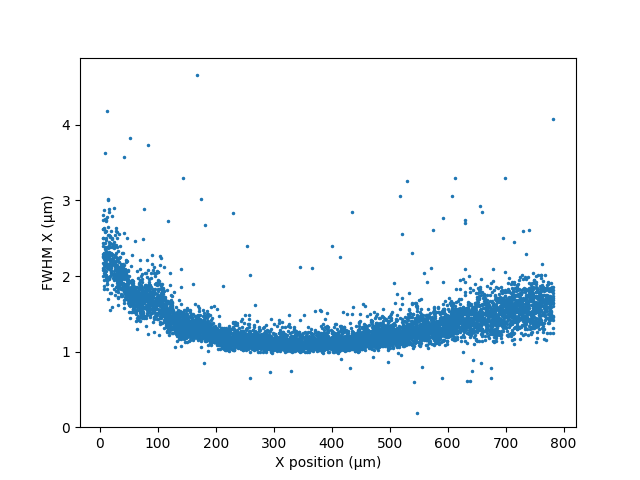

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='FWHM X (μm)'>)

In [8]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'FWHM_x'
v_label = 'FWHM X (μm)'

save_name = 'x_scatter_plot.pdf'

psf_plot.plot_scatter(h_ax,
                      v_ax,
                      save_name,
                      data_base_path,
                      data,
                      sampling,
                      save_plot=True,
                      h_label=h_label,
                      v_label=v_label,
#                       v_ax_lim=2.5,
                      h_ax_lims=[])

<IPython.core.display.Javascript object>


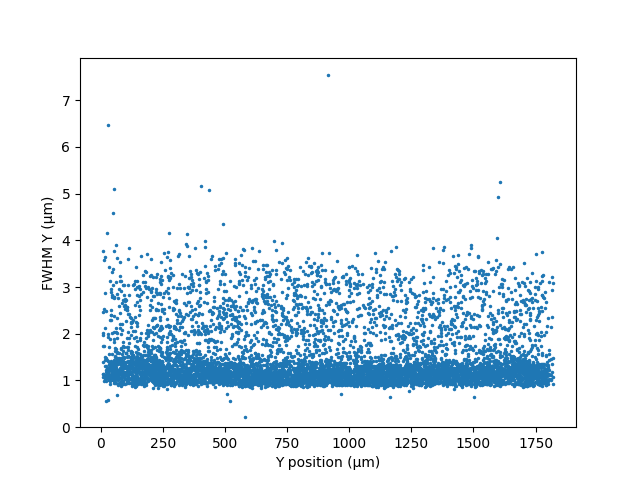

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Y position (μm)', ylabel='FWHM Y (μm)'>)

In [9]:
h_ax = 'y_center'
h_label = 'Y position (μm)'

v_ax = 'FWHM_y'
v_label = 'FWHM Y (μm)'

save_name = 'y_scatter_plot.pdf'

psf_plot.plot_scatter(h_ax,
                      v_ax,
                      save_name,
                      data_base_path,
                      data,
                      sampling,
                      save_plot=True,
                      h_label=h_label,
                      v_label=v_label,
#                       v_ax_lim=2.5,
                      h_ax_lims=[])

<IPython.core.display.Javascript object>


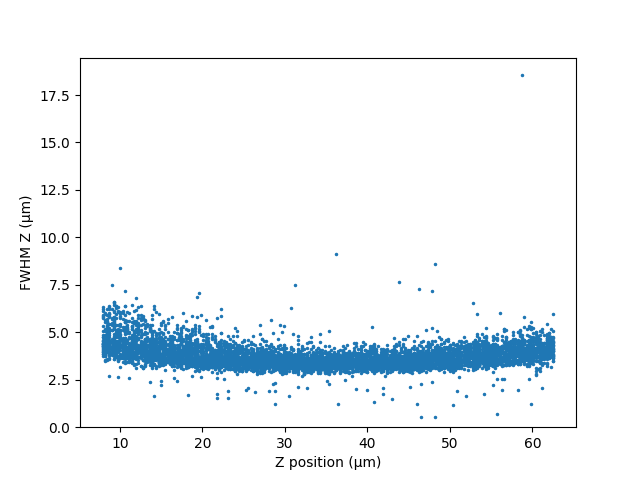

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Z position (μm)', ylabel='FWHM Z (μm)'>)

In [10]:
h_ax = 'z_center'
h_label = 'Z position (μm)'

v_ax = 'FWHM_z'
v_label = 'FWHM Z (μm)'

save_name = 'z_scatter_plot.pdf'

psf_plot.plot_scatter(h_ax,
                      v_ax,
                      save_name,
                      data_base_path,
                      data,
                      sampling,
                      save_plot=True,
                      h_label=h_label,
                      v_label=v_label,
#                       v_ax_lim=3,
                      h_ax_lims=[])

## Plot median values by bin along one axis

In [ ]:
### overlay binned medians

bin_data_unswept = (data['z_center']*sampling/np.sin(np.deg2rad(40))-770/4).tolist()
# bin_data = (data['z_center']*sampling).tolist()

stat_data_unswept = data['FWHM_z'].tolist()

<IPython.core.display.Javascript object>


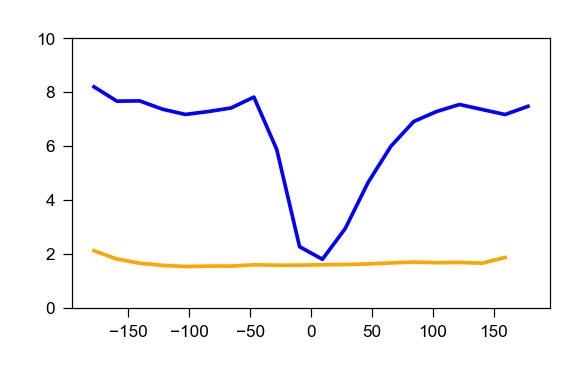

(0.0, 10.0)

In [42]:
bin_data = bin_data_swept
stat_data = stat_data_swept

statistic, bin_edges, binnumber = scipy.stats.binned_statistic(bin_data,
                                                               stat_data,
                                                               statistic='median',
                                                               bins=20,
                                                               range=(-375/2,375/2)
                                                              )
bin_mids = (bin_edges[1:] + bin_edges[:-1]) / 2

plt.subplots()
plt.plot(bin_mids,statistic,color='orange')
plt.ylim(0,10)

In [43]:
bin_data = bin_data_unswept
stat_data = stat_data_unswept

statistic, bin_edges, binnumber = scipy.stats.binned_statistic(bin_data,
                                                               stat_data,
                                                               statistic='median',
                                                               bins=20,
                                                               range=(-375/2,375/2)
                                                              )
bin_mids = (bin_edges[1:] + bin_edges[:-1]) / 2

#plt.subplots()
plt.plot(bin_mids,statistic,color='blue')
plt.ylim(0,10)

(0.0, 10.0)

## Plot single tile

C:\Users\AERB\AppData\Local\Temp\ipykernel_8772\2717605050.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_one_tile['z_center'] -= tile_min/sampling


<IPython.core.display.Javascript object>


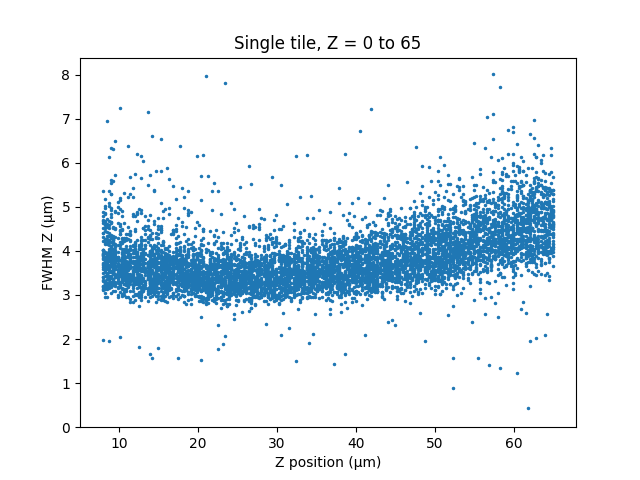

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Single tile, Z = 0 to 65'}, xlabel='Z position (μm)', ylabel='FWHM Z (μm)'>)

In [37]:
# plot only one tile
# NOTE: tile boundaries must be manually adjusted based on plot above
# multi-tile datasets may show discontinuities / artifacts at tile boundaries.
# Use this cell to manually crop data to a single tile

tile_min = 0
tile_max = 65

data_one_tile = data[(data['z_center']*sampling > tile_min) & (data['z_center']*sampling < tile_max)] 
data_one_tile['z_center'] -= tile_min/sampling

h_ax = 'z_center'
h_label = 'Z position (μm)'

v_ax = 'FWHM_z'
v_label = 'FWHM Z (μm)'

save_name = 'z_scatter_plot_single_tile.pdf'
title_string = 'Single tile, Z = ' + str(tile_min) + ' to ' + str(tile_max)



psf_plot.plot_scatter(h_ax,
                      v_ax,
                      save_name,
                      data_base_path,
                      data_one_tile,
                      sampling,
                      save_plot=True,
                      plot_title=title_string,
                      h_label=h_label,
                      v_label=v_label,
                      v_ax_lim=[],
                      h_ax_lims=[])

### Heatmaps

<IPython.core.display.Javascript object>


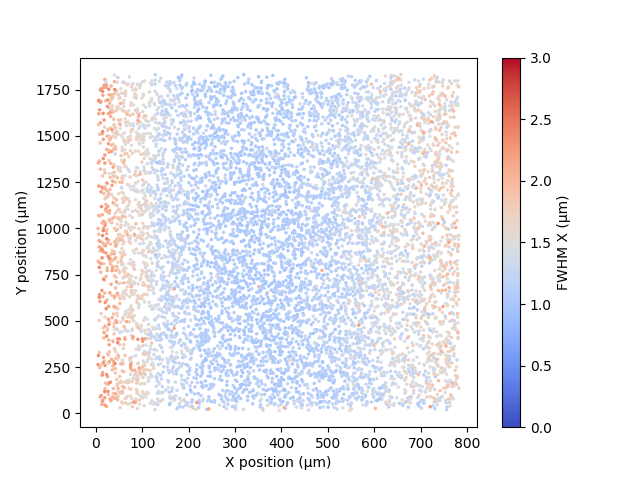

Plot NOT saved!


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='Y position (μm)'>)

In [38]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'y_center'
v_label = 'Y position (μm)'

color_ax = 'FWHM_x'
c_label = 'FWHM X (μm)'

save_name = 'xy-x_heatmap.pdf'
psf_plot.plot_scatter_heat(h_ax,
                           v_ax,
                           color_ax,
                           save_name,
                           data_base_path,
                           data_one_tile,
                           v_sampling=sampling,
                           h_sampling=sampling,
                           save_plot=False,
                           h_label=h_label,
                           v_label=v_label,
                           c_label=c_label,
                           base_map=mpl.colormaps['coolwarm'],
                           clim=[0,3],
                           percentile_lim=[1,99]
                          )


<IPython.core.display.Javascript object>


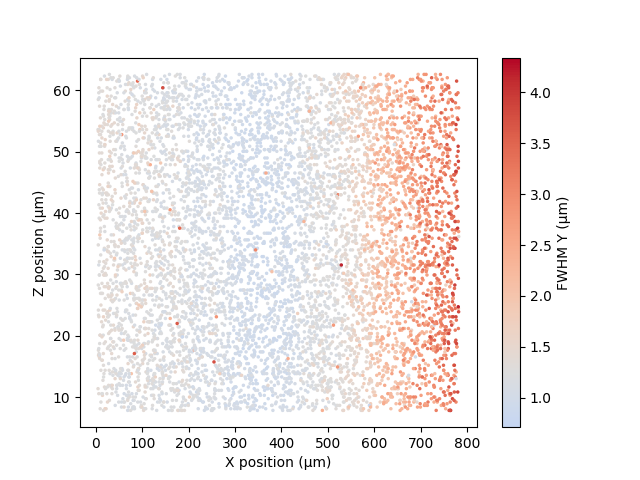

Saving plot


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='Z position (μm)'>)

In [15]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_y'
c_label = 'FWHM Y (μm)'

save_name = 'xz-y_heatmap.pdf'
psf_plot.plot_scatter_heat(h_ax,
                           v_ax,
                           color_ax,
                           save_name,
                           data_base_path,
                           data,
                           v_sampling=sampling,
                           h_sampling=sampling,
                           save_plot=True,
                           h_label=h_label,
                           v_label=v_label,
                           c_label=c_label,
                           base_map=mpl.colormaps['coolwarm'],
                           #clim=[0,7.0]
                          )


<IPython.core.display.Javascript object>


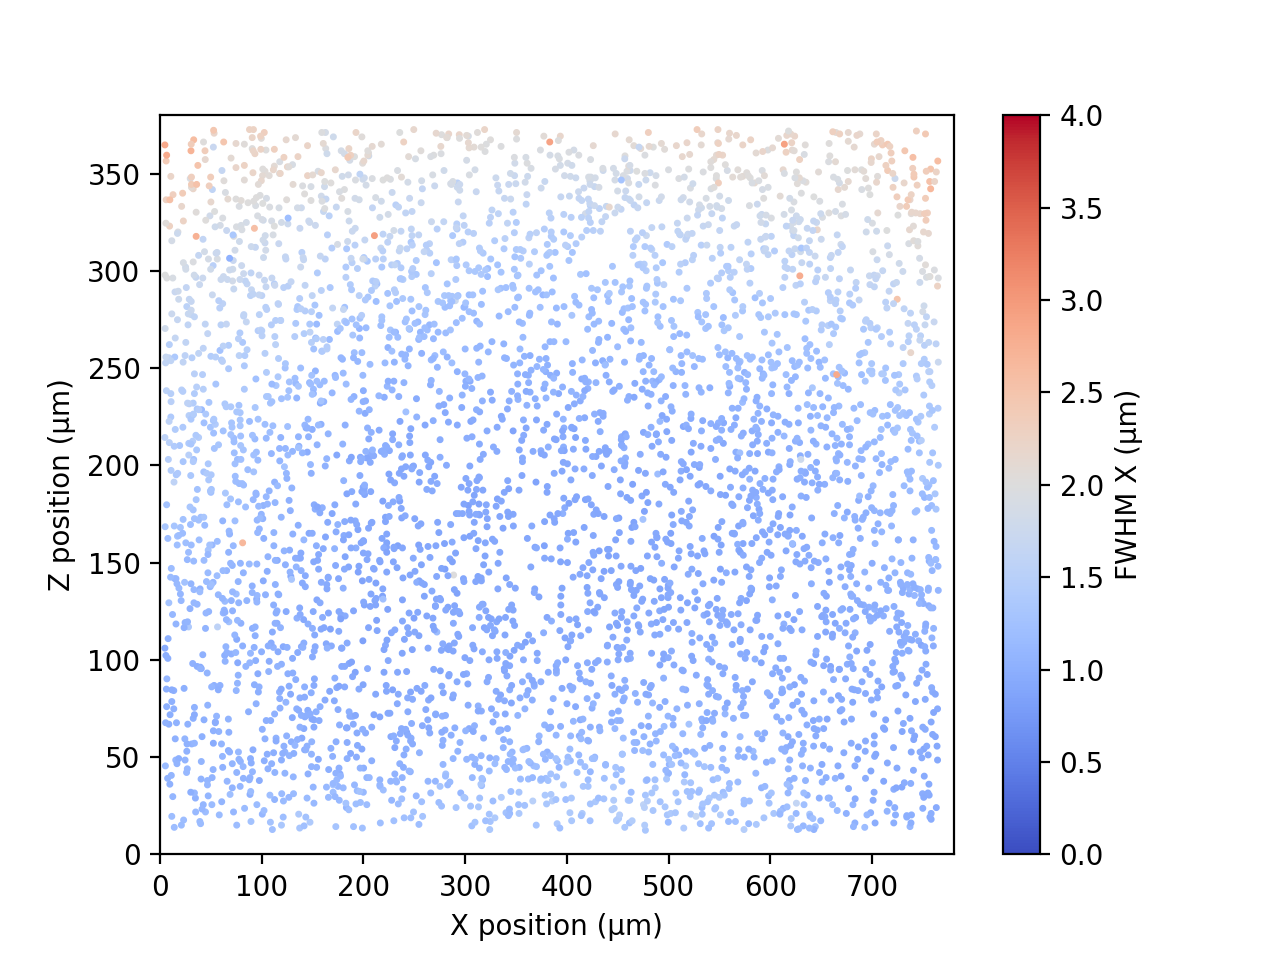

Saving plot


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='Z position (μm)'>)

In [77]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_x'
c_label = 'FWHM X (μm)'

save_name = 'xz-x_heatmap.pdf'

psf_plot.plot_scatter_heat(h_ax,
                           v_ax,
                           color_ax,
                           save_name,
                           data_base_path,
                           data,
                           h_sampling=sampling,
                           v_sampling=sampling/np.sin(np.deg2rad(40)),
                           save_plot=True,
                           h_label=h_label,
                           v_label=v_label,
                           c_label=c_label,
                           base_map=mpl.colormaps['coolwarm'],
                           clim=[0,4],
                           hlim=[0,780],
                           vlim=[0,380],
                           #vticks=[],
#                            cticks=[0,4,8,12],
#                            equal=True
                          )


<IPython.core.display.Javascript object>


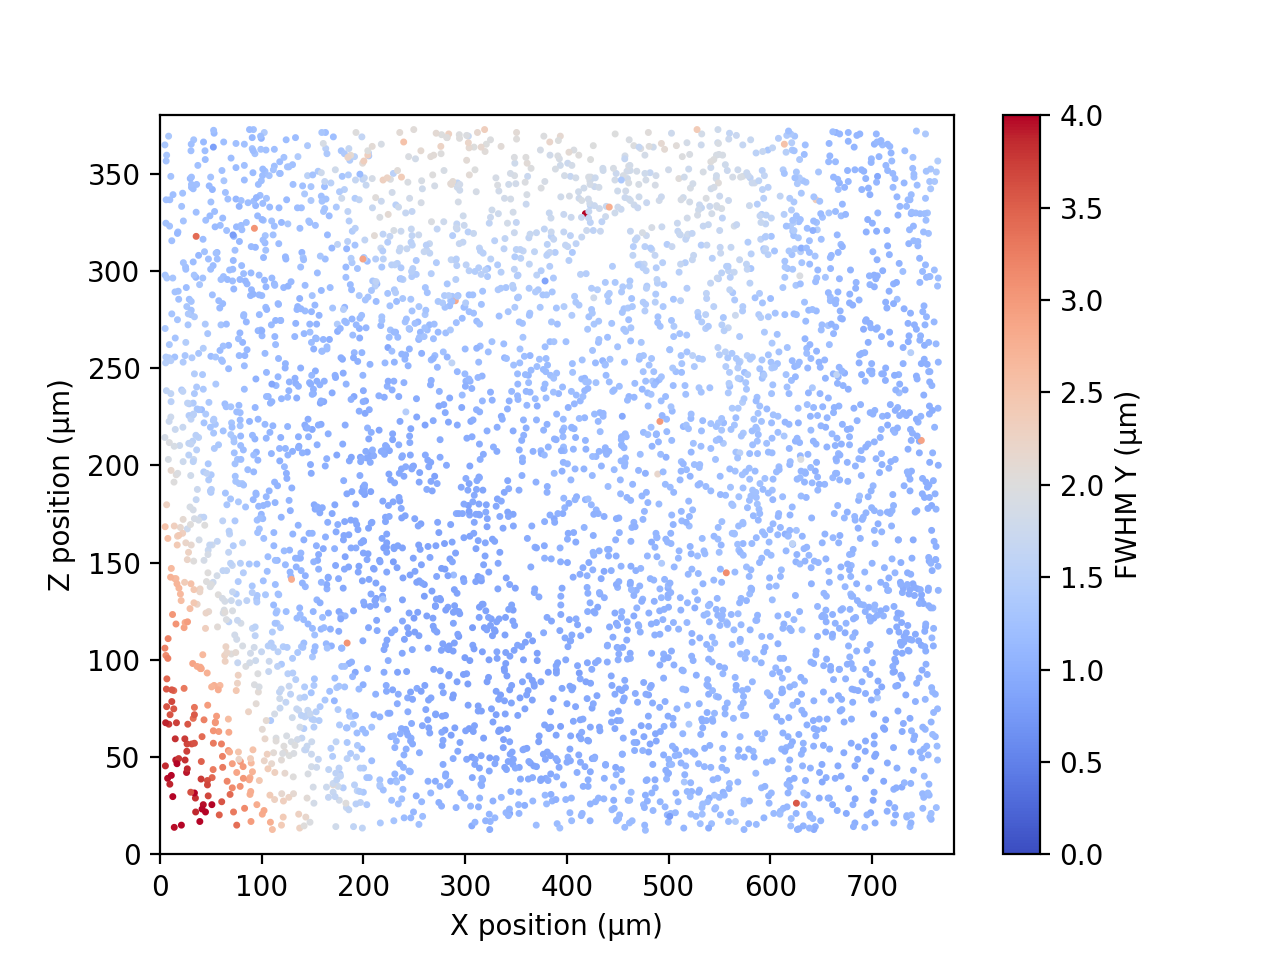

Saving plot


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='X position (μm)', ylabel='Z position (μm)'>)

In [78]:
h_ax = 'x_center'
h_label = 'X position (μm)'

v_ax = 'z_center'
v_label = 'Z position (μm)'

color_ax = 'FWHM_y'
c_label = 'FWHM Y (μm)'

save_name = 'xz-y_heatmap.pdf'

psf_plot.plot_scatter_heat(h_ax,
                           v_ax,
                           color_ax,
                           save_name,
                           data_base_path,
                           data,
                           h_sampling=sampling,
                           v_sampling=sampling/np.sin(np.deg2rad(40)),
                           save_plot=True,
                           h_label=h_label,
                           v_label=v_label,
                           c_label=c_label,
                           base_map=mpl.colormaps['coolwarm'],
                           clim=[0,4],
                           hlim=[0,780],
                           vlim=[0,380],
                           #vticks=[],
#                            cticks=[0,4,8,12],
#                            equal=True
                          )


<IPython.core.display.Javascript object>


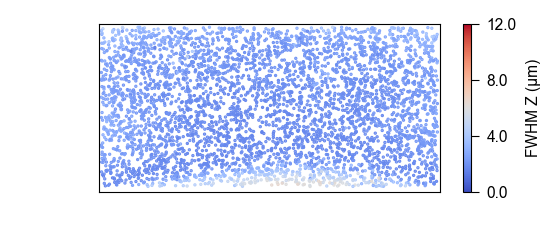

Saving plot


(<Figure size 280x120 with 2 Axes>, <Axes: >)

In [34]:
h_ax = 'x_center'
h_label = 'X position (μm)'
h_label = ''

v_ax = 'z_center'
v_label = 'Z position (μm)'
v_label = ''

color_ax = 'FWHM_z'
c_label = 'FWHM Z (μm)'

save_name = 'xz-z_heatmap.pdf'

psf_plot.plot_scatter_heat(h_ax,
                           v_ax,
                           color_ax,
                           save_name,
                           data_base_path,
                           data,
                           h_sampling=sampling,
                           v_sampling=sampling/np.sin(np.deg2rad(40)),
                           save_plot=True,
                           h_label=h_label,
                           v_label=v_label,
                           c_label=c_label,
                           base_map=mpl.colormaps['coolwarm'],
                           clim=[0,12],
                           hlim=[0,770],
                           vlim=[0,380],
                           vticks=[],
                           hticks=[],
                           cticks=[0,4,8,12],
                           equal=True
                          )


### Histograms

<IPython.core.display.Javascript object>


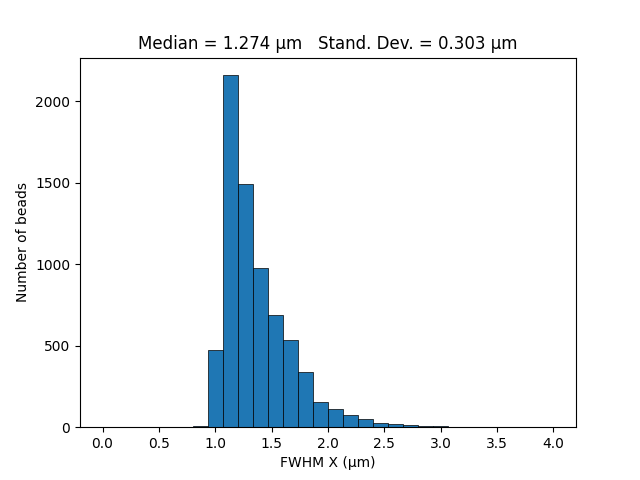

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Median = 1.274 μm   Stand. Dev. = 0.303 μm'}, xlabel='FWHM X (μm)', ylabel='Number of beads'>)

In [16]:
h_ax = 'FWHM_x'
h_label = 'FWHM X (μm)'
v_label = 'Number of beads'
h_max_lim = 4
save_name = 'x_histo.pdf'

psf_plot.plot_histo(h_ax,
                    h_max_lim,
                    save_name,data_base_path,
                    data,
                    save_plot=True,
                    h_label=h_label,
                    v_label=v_label
                   )

<IPython.core.display.Javascript object>


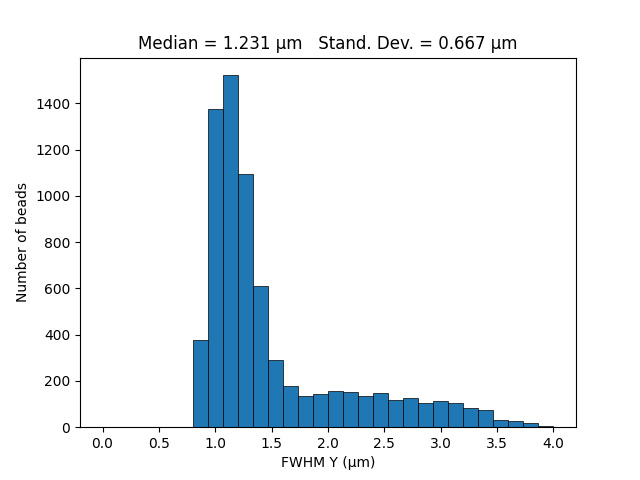

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Median = 1.231 μm   Stand. Dev. = 0.667 μm'}, xlabel='FWHM Y (μm)', ylabel='Number of beads'>)

In [17]:
h_ax = 'FWHM_y'
h_label = 'FWHM Y (μm)'
v_label = 'Number of beads'
h_max_lim = 4
save_name = 'y_histo.pdf'

psf_plot.plot_histo(h_ax,
                    h_max_lim,
                    save_name,data_base_path,
                    data,
                    save_plot=True,
                    h_label=h_label,
                    v_label=v_label
                   )

<IPython.core.display.Javascript object>


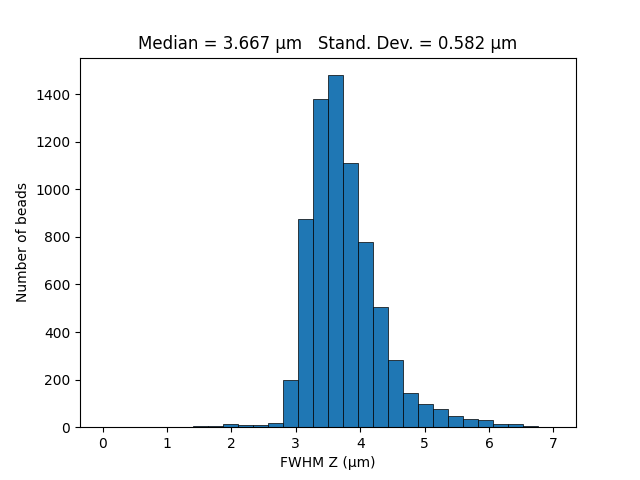

Saving plot


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Median = 3.667 μm   Stand. Dev. = 0.582 μm'}, xlabel='FWHM Z (μm)', ylabel='Number of beads'>)

In [18]:
h_ax = 'FWHM_z'
h_label = 'FWHM Z (μm)'
v_label = 'Number of beads'
h_max_lim = 7
save_name = 'z_histo.pdf'

psf_plot.plot_histo(h_ax,
                    h_max_lim,
                    save_name,data_base_path,
                    data,
                    save_plot=True,
                    h_label=h_label,
                    v_label=v_label
                   )

In [ ]:
# Plot rotation histograms (see note on rotation parameter above)
# Note that demo data does not include rotation, so this cell will not work

if 'rotx' in data.columns:
    plt.subplots()
    plt.hist(data['rotx'],bins=20,fill='red',alpha=0.2)
    plt.hist(data['roty'],bins=21,fill='blue',alpha=0.2)
    plt.hist(data['rotz'],bins=22,fill='green',alpha=0.2)
else:
    raise Exception('No rotation in this dataset')


## Plot average Gaussian fit
This plot is a 2D slices of the average 3D Gaussian curve fit to the beads. Because this is computed analytically from the average fit parameters, the plot can be smoothed for any plot size. The plot will always be symmetric along the horizontal axis and along the vertical axis (even if the average PSF is not).

In [55]:
# x: 0 - 780
# z: 0 - 390

x_min = 0 #780/2-50
x_max = 100 #780/2+50
z_min = 340
z_max = 390


data_roi = data.loc[(data['x_center']*sampling >= x_min) & 
                    (data['x_center']*sampling <= x_max) &
                    (data['z_center']*sampling/np.sin(np.deg2rad(40)) >= z_min) & 
                    (data['z_center']*sampling/np.sin(np.deg2rad(40)) <= z_max)]
data_roi.reset_index(inplace=True,drop=True)



<IPython.core.display.Javascript object>


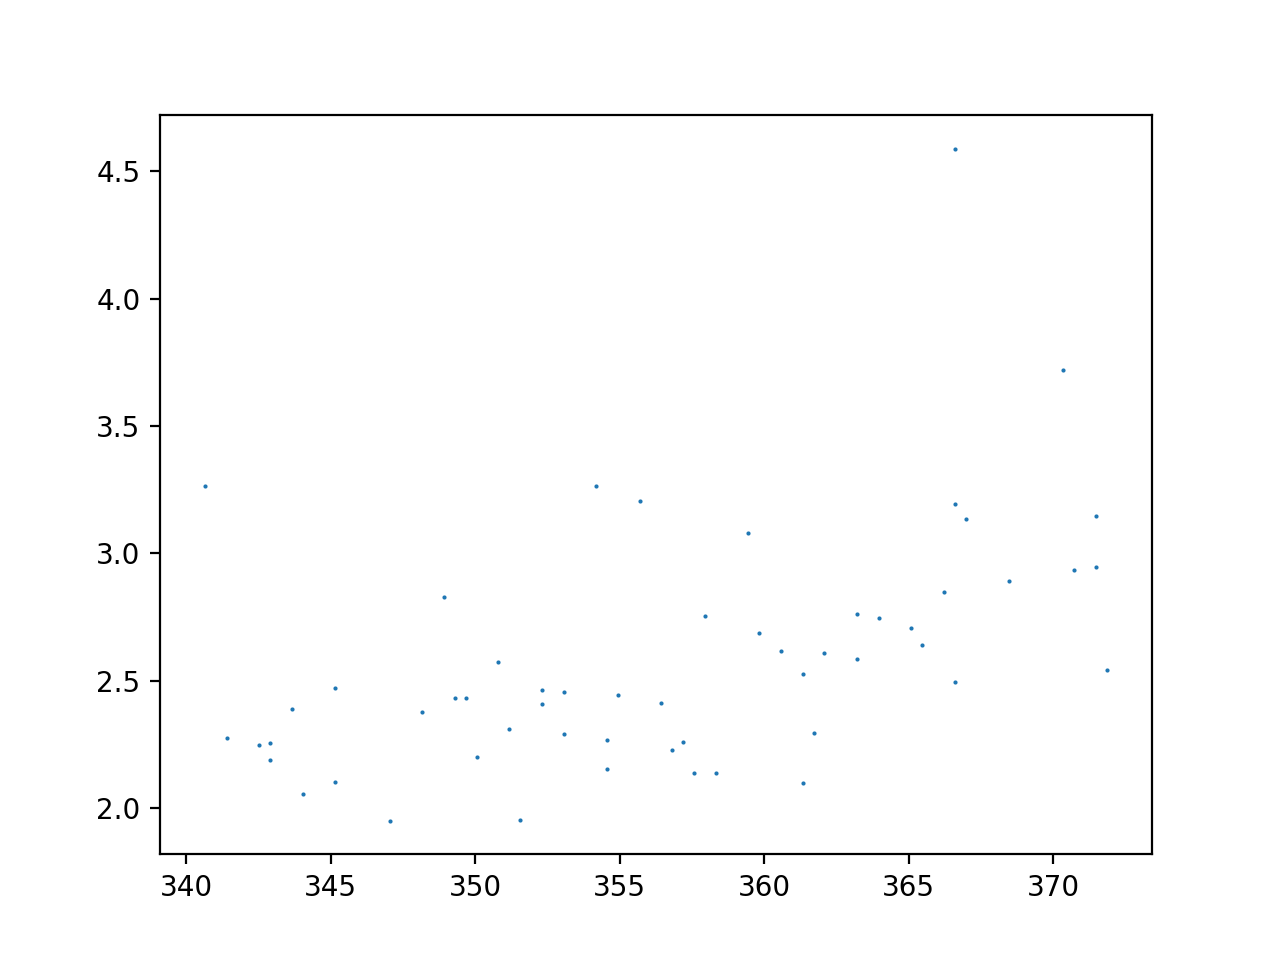

In [56]:
plt.subplots()
plt.scatter(data_roi['z_center']*sampling/np.sin(np.deg2rad(40)),
            data_roi['FWHM_z'],
            marker='.',linewidth=0)

<IPython.core.display.Javascript object>


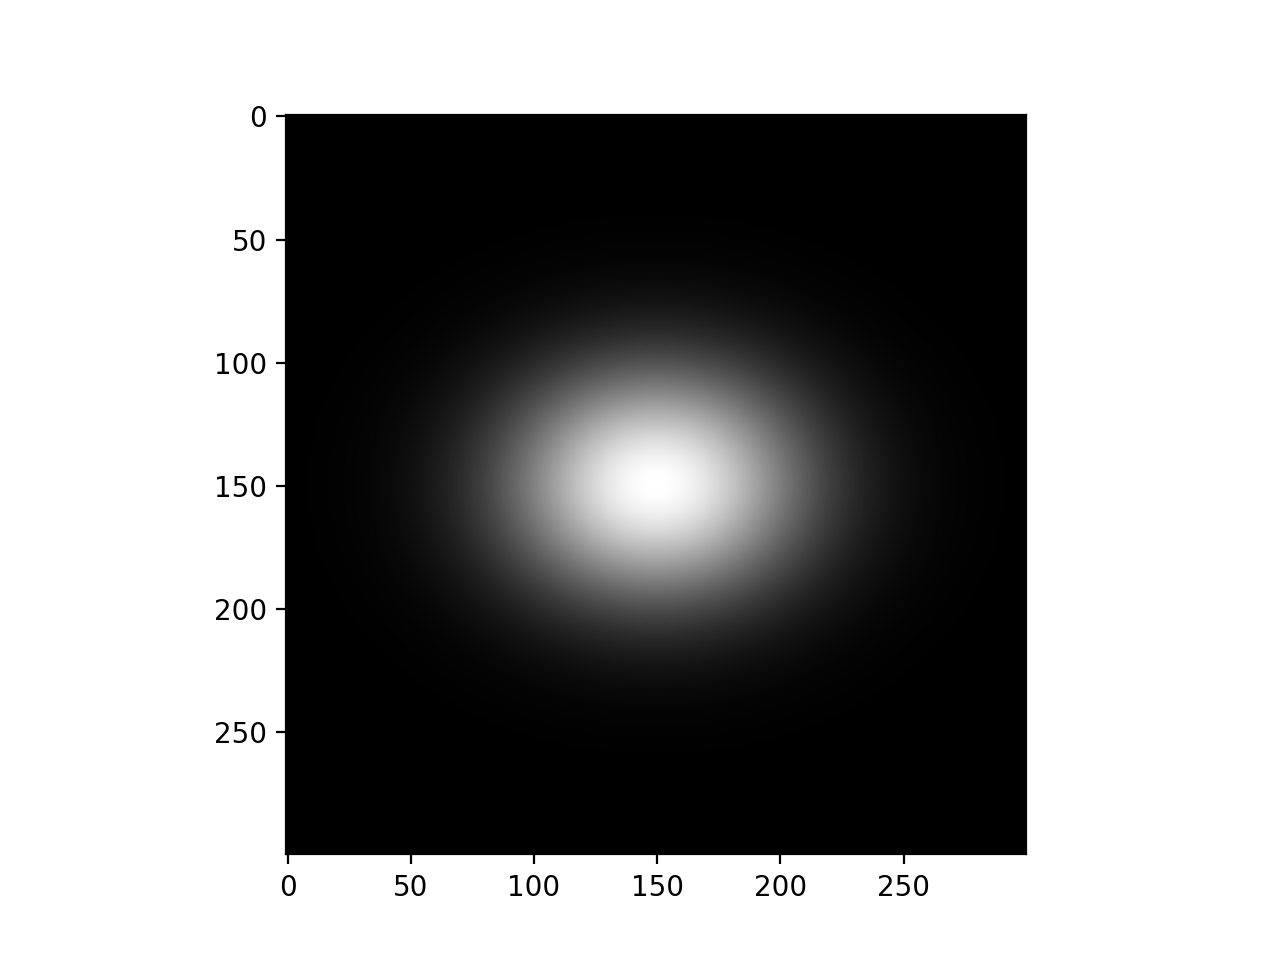

Plot NOT saved!


(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [51]:
# Something about this isn't working properly, confirm it's not causing other problems

# 0 for x, 1 for y, 2 for z
h_ax = 1 # horizontal dimension
v_ax = 2 # vertical dimension
save_name = 'avg_fit_yz.tif'

psf_plot.plot_avg_fit(h_ax=h_ax,
                      v_ax=v_ax,
                      save_name=save_name,
                      data_base_path=data_base_path,
                      data_in=data_roi,
                      save_plot=False,
                      axis=True
                     )


## Plot average PSFs (slices)
Use caution when interpreting average PSFs - some aberrations will distort the PSFs in opposite ways at each side of the field of view, etc. For instance, if a PSF stretches to have an upward tail at the left side of the FOV and a downward tail at the right side of the FOV, the average PSF would still look symmetric (as these distortions would cancel each other out).

(66, 34, 34)


<IPython.core.display.Javascript object>


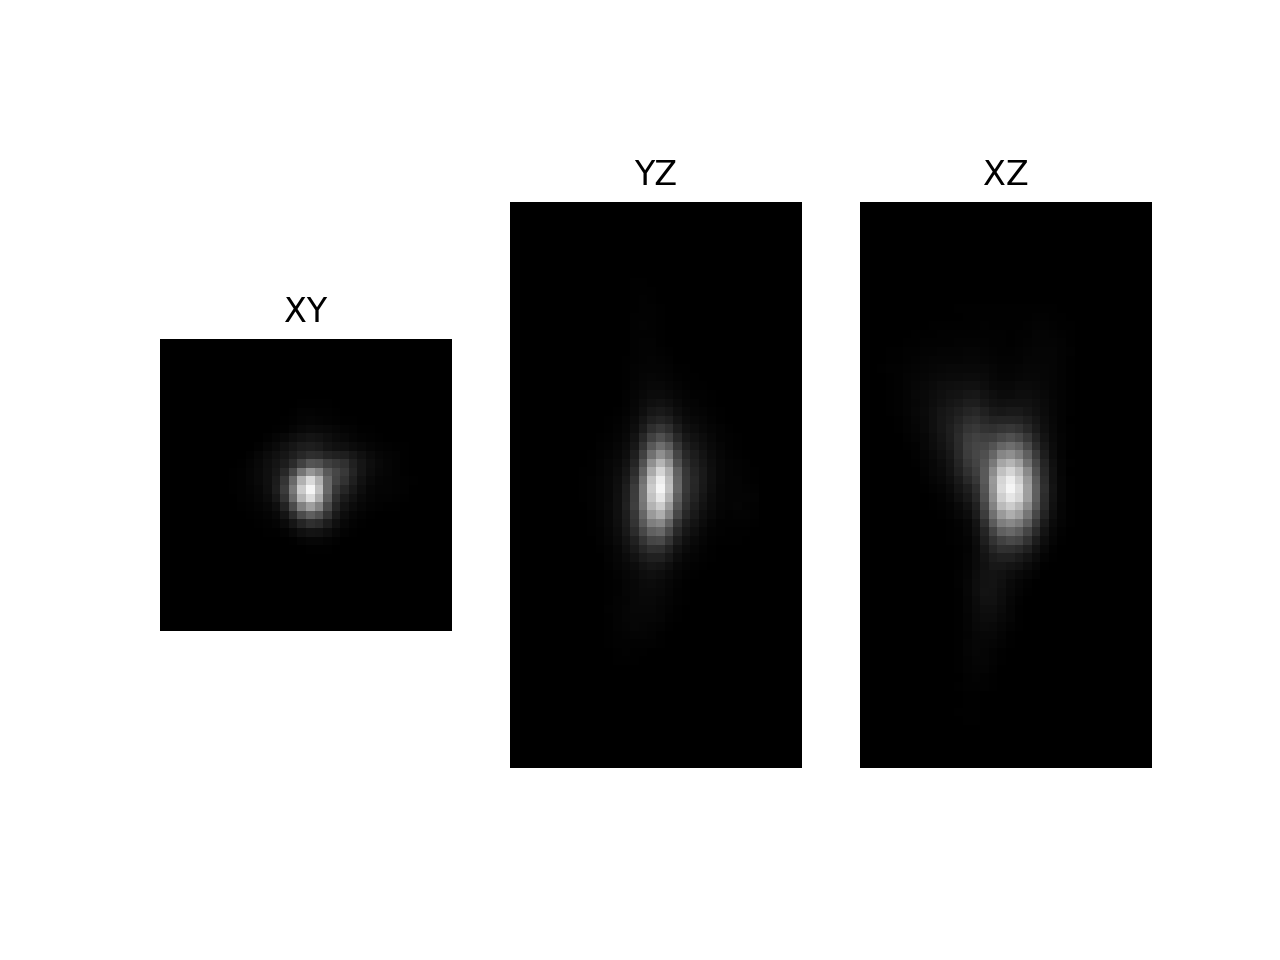

Text(0.5, 1.0, 'XZ')

In [57]:
plot_set=data_roi

average_psf = np.zeros(plot_set['bead'][0].shape)

for i in range (plot_set['bead'].shape[0]):
    average_psf = average_psf + plot_set['bead'][i]

average_psf = average_psf/plot_set['bead'].shape
print(average_psf.shape)
fig, axs = plt.subplots(1,3)

XY = average_psf[int(average_psf.shape[0]/2),:,:]
YZ = average_psf[:,int(average_psf.shape[1]/2),:]
XZ = average_psf[:,:,int(average_psf.shape[2]/2)]

axs[0].imshow(XY, vmin = 0, vmax = 1, cmap='gray');
axs[0].axis('off');
axs[0].set_title('XY')

axs[1].imshow(YZ, vmin = 0, vmax = 1, cmap='gray');
axs[1].axis('off');
axs[1].set_title('YZ')

axs[2].imshow(XZ, vmin = 0, vmax = 1, cmap='gray');
axs[2].axis('off');
axs[2].set_title('XZ')



In [ ]:
save_path = os.path.join(data_base_path, 'XZ.tif')
if not os.path.exists(save_path):
    imsave(save_path,(XZ*255).astype('uint8'))
else:
    raise Exception('File already exists')
    
save_path = os.path.join(data_base_path, 'YZ.tif')
if not os.path.exists(save_path):
    imsave(save_path,(YZ*255).astype('uint8'))
else:
    raise Exception('File already exists')
    
save_path = os.path.join(data_base_path, 'XY.tif')
if not os.path.exists(save_path):
    imsave(save_path,(XY*255).astype('uint8'))
else:
    raise Exception('File already exists')

## Plot average PSFs (projections)

<IPython.core.display.Javascript object>


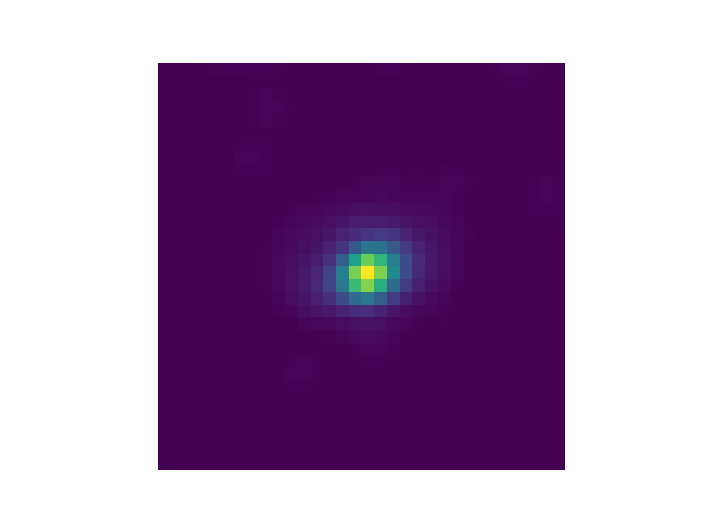

In [27]:
plt.subplots()
plt.imshow(average_psf.max(axis=0));
plt.axis('off');

<IPython.core.display.Javascript object>


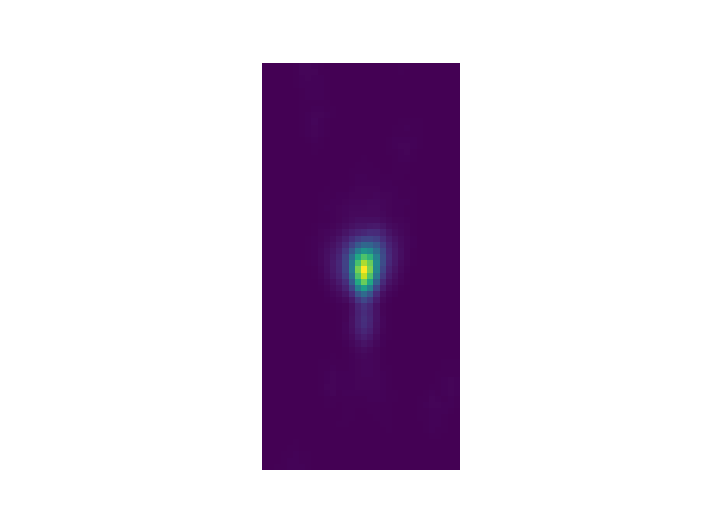

In [30]:
plt.subplots()
plt.imshow(average_psf.max(axis=1), aspect = options['pxPerUmLat']/options['pxPerUmAx']);
plt.axis('off');

<IPython.core.display.Javascript object>


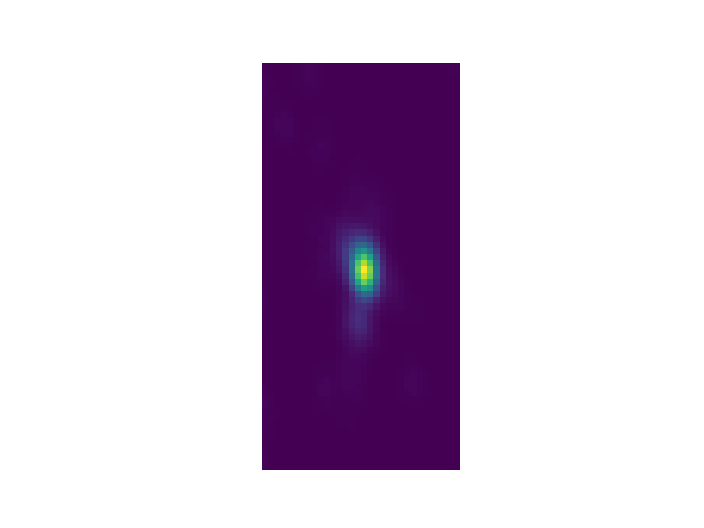

In [32]:
plt.subplots()
plt.imshow(average_psf.max(axis=2), aspect = options['pxPerUmLat']/options['pxPerUmAx']);
plt.axis('off');

***
***
*The rest of the script cannot be run with loaded (previously computed) data as the complete PSFs are not stored. To run the below sections, the PSFs must be recomputed from the raw data (above)*

## Plot max projection of bead locations

In [34]:
smoothed.size

6502090752

<IPython.core.display.Javascript object>


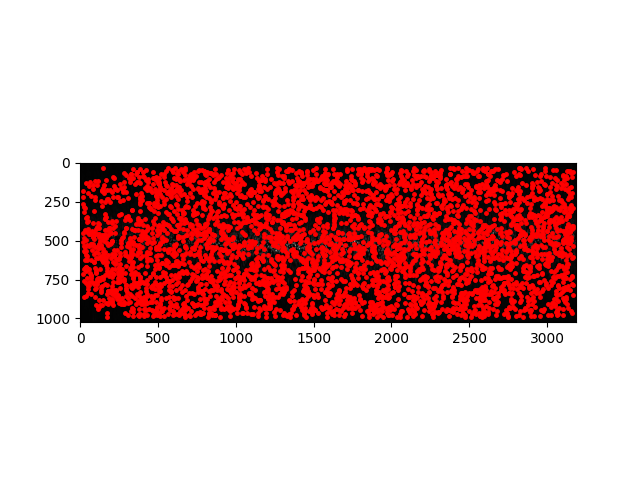

In [23]:
plt.subplots()
slice_ax = 1
plt.imshow(smoothed.max(slice_ax), vmin = 0, vmax = 10000, cmap='gray');

if slice_ax == 0:
    plt.plot(data['x_center'], data['y_center'], 'r.', ms=5);
elif slice_ax == 1:
    plt.plot(data['x_center'], data['z_center'], 'r.', ms=5);
elif slice_ax == 2:
    plt.plot(data['y_center'], data['z_center'], 'r.', ms=5);
# uncomment below to zoom in on plot
# plt.xlim([0, 0+smoothed.shape[0]/4])
# plt.ylim([smoothed.shape[1]/4, 500])
#plt.axis('off');